# Make your own surface data

CTSM needs lots of surface variables to run. 

CTSM technical notes has the official tutorial for creating surface datasets.

[**CTSM technical notes 1.3.5 Creating Surface data**](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/users_guide/using-clm-tools/creating-surface-datasets.html)

However, it is difficult to use the tool for users that are not familiar to CESM/CTSM. Because in pyclmuapp, we mainly focus on urban climate and the percentage of urban is set to 100%, which means the output are only urban related. Hence, we can easily over-write the urban surface data in the default `surfdata.nc` provided by pyclmuapp, this avoids the complex steps of using the mksurfdata_map tools.

---

**How to get our own urban surface data of the interest point from CESM provided file**

Ref: [Technical Description of an Urban Parameterization for the Community Land Model (CLMU)](https://www.researchgate.net/publication/261062625_Technical_Description_of_an_Urban_Parameterization_for_the_Community_Land_Model_CLMU),
    [Table 3 Input data required for the urban model](https://www.researchgate.net/figure/3-Input-data-required-for-the-urban-model_tbl1_261062625)


Workflow:

1. get the urban surface input from [`mksrf_urban_0.05x0.05_simyr2000.c170724.nc`](https://svn-ccsm-inputdata.cgd.ucar.edu/trunk/inputdata/lnd/clm2/rawdata/)
2. get the soil parameter for the pervious road in urban from [`mksrf_soitex.10level.c010119.nc`](https://svn-ccsm-inputdata.cgd.ucar.edu/trunk/inputdata/lnd/clm2/rawdata/)

In [1]:
from pyclmuapp import usp_clmu
from pyclmuapp import get_urban_params
from matplotlib import pyplot as plt
import xarray as xr
import os

### Step 2: generate a surfdata.nc

Here we use the Vancouver city urban surface input file privdied by CTSM default case to generate the default surface data. 

We can aslo use the `surfdata.nc` provdied by pyclmuapp as template.

**fist, let's check the mksrf_urban_0.05x0.05_simyr2000.c120621.nc**

Region 0: 348 grid cells
Region 1: 74945 grid cells
Region 2: 278922 grid cells


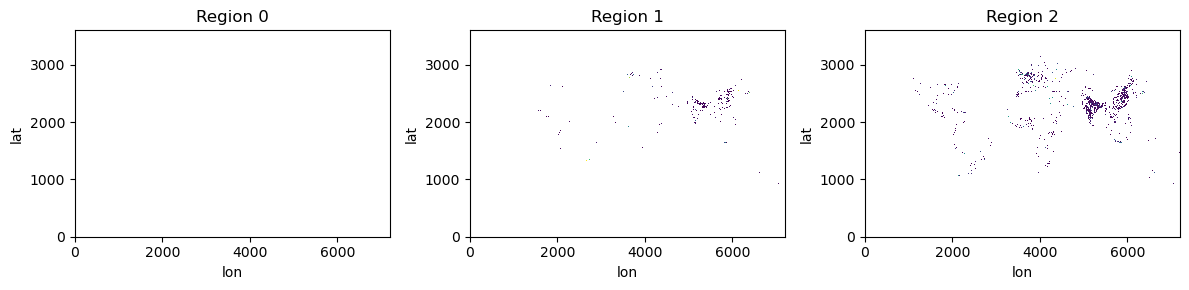

In [2]:
# open the downloaded mksrf_urban_0.05x0.05_simyr2000.c120621.nc
global_surf = xr.open_dataset('data/mksrf_urban_0.05x0.05_simyr2000.c120621.nc')
fig = plt.figure(figsize=(12, 3))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    global_surf['PCT_URBAN'].sel(density_class=i).where(global_surf['PCT_URBAN'].sel(density_class=i) > 0).plot(ax=ax, add_colorbar=False)
    print(f"Region {i}:", global_surf['PCT_URBAN'].sel(density_class=i).where(global_surf['PCT_URBAN'].sel(density_class=i) > 0).count().values, "grid cells")
    ax.set_title(f'Region {i}')
plt.tight_layout()
plt.show()

**then check mksrf_soitex.10level.c010119.nc**

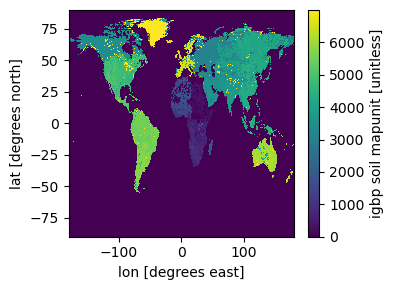

In [3]:
soil = xr.open_dataset('data/mksrf_soitex.10level.c010119.nc')
soil = soil.assign_coords(lat=soil.LAT, lon=soil.LON)   # add lat and lon as coordinates
fig = plt.figure(figsize=(4, 3))
soil['MAPUNITS'].plot()
plt.tight_layout()
plt.show()

**generate the surfdata.nc file**

add the nevlurb to 10

In [4]:
ds_global = xr.open_dataset('/Users/user/Documents/GitHub/pyclmuapp/data/mksrf_urban_0.05x0.05_simyr2000.c170724.nc')
ds_global = ds_global.assign_coords(lat=ds_global.LAT, lon=ds_global.LON)   # add lat and lon as coordinates
#ds_global.sel(lat=49.5, lon=236.5-360, method='nearest')['REGION_ID'].values  # 6
dd = ds_global.sel(lat=53.4808, lon=236.5-360, method='nearest')
dd = dd.sel(region=dd.REGION_ID.values-1)
dd

<xarray.Dataset>
Dimensions:          (density_class: 3, numsolar: 2, numrad: 2, nlevurb: 10)
Coordinates:
    lat              float64 53.47
    lon              float64 -123.5
Dimensions without coordinates: density_class, numsolar, numrad, nlevurb
Data variables: (12/31)
    LANDMASK         int8 ...
    LAT              float64 ...
    LON              float64 ...
    LATIXY           float64 ...
    LONGXY           float64 ...
    PCT_URBAN        (density_class) float64 ...
    ...               ...
    CV_IMPROAD       (nlevurb, density_class) float32 ...
    NLEV_IMPROAD     (density_class) float32 ...
    THICK_ROOF       (density_class) float32 ...
    THICK_WALL       (density_class) float32 ...
    T_BUILDING_MIN   (density_class) float32 ...
    T_BUILDING_MAX   (density_class) float32 ...
Attributes:
    date:     Mon Jul 24 10:08:51 MDT 2017
    source:   /glade/p/cgd/tss/people/oleson/urban_sfcdata/Feddema_urban_data...
    case_id:  Feddema/Jackson region_prop.170724-090103.csv (from urban prope...
    title:    Urban parameters for TBD,HD, and MD classes - Dominant - Lamina...

In [5]:
dd['LONGXY'].values, dd['LATIXY'].values, dd['REGION_ID'].values

(array(-123.475), array(53.475), array(6, dtype=int8))

In [6]:
import numpy as np
ds = xr.open_dataset('/Users/user/Documents/GitHub/pyclmuapp/data/surfdata_1x1_vancouverCAN_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc')
for var in ['TK_IMPROAD', 'TK_ROOF', 'TK_WALL', 'CV_IMPROAD', 'CV_ROOF', 'CV_WALL']:
    del ds[var]
ds=ds.assign(nlevurb=(np.array(range(0, 10), dtype=np.int32)))
#ds['nlevurb'].values = np.array(range(1, 11), dtype=np.int32)
ds['LONGXY'].values, ds['LATIXY'].values
for var in ['TK_IMPROAD', 'TK_ROOF', 'TK_WALL', 'CV_IMPROAD', 'CV_ROOF', 'CV_WALL']:
    ds = ds.assign({var: (['nlevurb', 'numurbl', 'lsmlat', 'lsmlon'], dd[var].values.reshape(10, 3, 1, 1))})
    ds[var].attrs = dd[var].attrs
ds.to_netcdf('data/surfdata_1x1_vancouverCAN_hist_16pfts_Irrig_CMIP6_simyr2000_c190214_10levurb.nc')

In [7]:
%time
urban = get_urban_params(urban_ds='data/mksrf_urban_0.05x0.05_simyr2000.c170724.nc', # can be a xarray dataset or a path to a netcdf file
                 soil_ds='data/mksrf_soitex.10level.c010119.nc', # can be a xarray dataset or a path to a netcdf file
                 # here we use the default vancouverCAN dataset provided by CLM5.0 as template
                 template='data/surfdata_1x1_vancouverCAN_hist_16pfts_Irrig_CMIP6_simyr2000_c190214_10levurb.nc',
                 lat = 51.5116,
                 lon = -0.1167,
                 PTC_URBAN=[0,0,100.0], # percentage of urban land use in each density class, sum should be 100 
                 # this means that the urban land use is 100% in the MD class
                 outputname='data/surfdata.nc',)
urban # the created surfdata.nc file

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 1.91 µs
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
Found suitable point at lat: 51.4116, lon: -0.1167
Found suitable point at lat: 51.4116, lon: -0.1167


<xarray.Dataset>
Dimensions:                  (lsmlat: 1, lsmlon: 1, nlevsoi: 10, natpft: 15,
                              cft: 2, time: 12, lsmpft: 17, numurbl: 3,
                              numrad: 2, nglcecp1: 11, nglcec: 10, nlevurb: 10)
Coordinates:
  * natpft                   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft                      (cft) int32 15 16
  * time                     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lsmlat                   (lsmlat) int32 1
  * lsmlon                   (lsmlon) int32 1
  * numrad                   (numrad) int32 1 2
  * numurbl                  (numurbl) int32 1 2 3
  * nlevurb                  (nlevurb) int32 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: nlevsoi, lsmpft, nglcecp1, nglcec
Data variables: (12/77)
    mxsoil_color             int32 ...
    SOIL_COLOR               (lsmlat, lsmlon) int32 ...
    PCT_SAND                 (nlevsoi, lsmlat, lsmlon) float64 44.75 ... 42.18
    PCT_CLAY                 (nlevsoi, lsmlat, lsmlon) float64 28.61 ... 29.93
    ORGANIC                  (nlevsoi, lsmlat, lsmlon) float64 ...
    FMAX                     (lsmlat, lsmlon) float64 ...
    ...                       ...
    TK_IMPROAD               (nlevurb, numurbl, lsmlat, lsmlon) float32 1.9 ....
    TK_ROOF                  (nlevurb, numurbl, lsmlat, lsmlon) float32 45.0 ...
    TK_WALL                  (nlevurb, numurbl, lsmlat, lsmlon) float32 2.27 ...
    CV_IMPROAD               (nlevurb, numurbl, lsmlat, lsmlon) float32 2.1e+...
    CV_ROOF                  (nlevurb, numurbl, lsmlat, lsmlon) float32 3.744...
    CV_WALL                  (nlevurb, numurbl, lsmlat, lsmlon) float32 2.118...
Attributes: (12/52)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 02-14-19 10:18:01
    Logname:                              erik
    Host:                                 cheyenne3
    Source:                               Community Land Model: CLM5
    Version:                              release-clm5.0.18/gpfs/fs1/scratch/...
    ...                                   ...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    zero_out_pft_override:                TRUE
    history:                              Thu Feb 14 10:18:15 2019: ncks -A -...
    history_of_appended_files:            Thu Feb 14 10:18:15 2019: Appended ...
    NCO:                                  netCDF Operators version 4.7.4 (htt...

In [8]:
urban['URBAN_REGION_ID'].values, urban['LONGXY'].values, urban['LATIXY'].values

(array([[19]], dtype=int32), array([[359.875]]), array([[51.525]]))